In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader
import syft as sy
import math
import sklearn.metrics as metrics      

In [2]:
admissions = pd.read_csv('./mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv')
patients = pd.read_csv('./mimic-iii-clinical-database-demo-1.4/PATIENTS.csv')
drgcodes = pd.read_csv('./mimic-iii-clinical-database-demo-1.4/DRGCODES.csv')
prescriptions = pd.read_csv('./mimic-iii-clinical-database-demo-1.4/PRESCRIPTIONS.csv')

In [3]:
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
patients['dob'] = pd.to_datetime(patients['dob'])
prescriptions['startdate'] = pd.to_datetime(prescriptions['startdate'])

In [4]:
temp_df = pd.merge(admissions,patients,on='subject_id')
temp_df['age'] = temp_df['admittime'].dt.year - temp_df['dob'].dt.year
temp_df = temp_df[temp_df['age']<=100]

In [5]:
mortality_list = []
for x in temp_df['deathtime']:
    if x!=x:
        mortality_list.append(0)
    else:
        mortality_list.append(1)
temp_df['mortality'] = mortality_list

In [7]:
df = pd.merge(temp_df,prescriptions,on='subject_id')
df = df[pd.notnull(df['icustay_id'])]
df['durg_time_diff'] = df['startdate']-pd.to_datetime(df['admittime'].dt.date)
df = df[df['durg_time_diff'] <= '2days']

In [8]:
data = df[['subject_id','drug','mortality']]
data = data.reset_index().drop('index',axis=1)

In [9]:
data['drug'] = data['drug'].astype('category')
data = pd.get_dummies(data,prefix='', prefix_sep='')

In [11]:
shuffled = data.sample(frac=1)
result = np.array_split(shuffled, 5)

In [12]:
def train_prep(df):
    train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
    x_train = train.iloc[:,2:]
    y_train = train['mortality']
    x_test = test.iloc[:,2:]
    y_test = test['mortality']
    x_val = validate.iloc[:,2:]
    y_val = validate['mortality']
    x_train = x_train.values
    y_train = y_train.values
    x_test = x_test.values
    y_test = y_test.values
    x_val = x_val.values
    y_val = y_val.values
    x_train = torch.from_numpy(x_train.astype(np.float32))
    y_train = torch.from_numpy(y_train.astype(np.float32)).view(-1,1)
    return x_train,y_train,x_test,y_test,x_val,y_val

In [13]:
class Net(nn.Module):
    
    def __init__(self,input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape, 256)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 100)
        self.dropout = nn.Dropout(0.2)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        self.fc3 = nn.Linear(100,1)

    def forward(self,x):
        a1 = self.fc1(x)
        h1 = self.relu1(a1)
        dout = self.dropout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        dout2 = self.dropout(h2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x

In [14]:
learning_rate = 0.01
epochs = 500
loss_fn = nn.BCELoss()

In [15]:
AllModels =list()
for i in range(5):
    model = Net(input_shape = result[i].shape[1]-2)
    AllModels.append(model)

In [18]:
y_test_dict = {}
prediction = {}
old_params = {}
para_dict={}
for k in range(10):
    for i in range(5):
        for j in range(epochs+1):
            model = AllModels[i]
            optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
            x_train,y_train,x_test,y_test,x_val,y_val = train_prep(result[i])
            y_test_dict[i] = y_test
            y_pred = model(x_train)
            loss = loss_fn(y_pred,y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        predicted = model(torch.tensor(x_test,dtype=torch.float32)).detach()
        prediction[i] = predicted
        std = [torch.std(v) for _,v in prediction.items()]
        weight = [std[i].detach().numpy().item()*len(result[i]) for i in range(len(std))]

    for s in range(5):
        for name, params in AllModels[s].named_parameters():
            old_params[name] = params.clone().detach()
            if name not in para_dict.keys():
                para_dict[name] = old_params[name]
            else:
                para_dict[name] += old_params[name]
    
    for s in range(5):          
        for name,params in para_dict.items():
            para_dict[name] = params * weight[s] / sum(weight)
        for name, params in AllModels[s].named_parameters():
            params.data.copy_(para_dict[name])

In [69]:
ytest_dict = y_test_dict.copy()

ytest = np.concatenate((ytest_dict[0], ytest_dict[1],ytest_dict[2],ytest_dict[3],ytest_dict[4]))

In [70]:
preds = prediction.copy()

preds = np.concatenate((preds[0], preds[1],preds[2],preds[3],preds[4]))

In [77]:
fpr, tpr, threshold = metrics.roc_curve(ytest, preds)
roc_auc = metrics.auc(fpr, tpr)

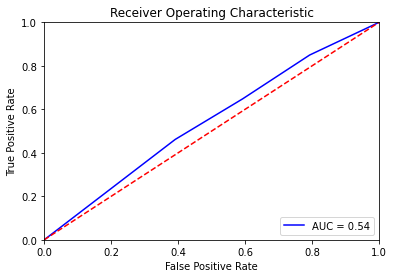

In [80]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()